In [1]:
#### Task 2

import numpy as np
from matplotlib import pyplot as plt
import os
import pickle
import time
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from scipy import interpolate
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))

def TMSD(traj, t_lags):
    ttt = np.zeros_like(t_lags, dtype= float)
    for idx, t in enumerate(t_lags): 
        for p in range(len(traj)-t):
            ttt[idx] += (traj[p]-traj[p+t])**2            
        ttt[idx] /= len(traj)-t    
    return ttt

def aging(traj, twind):
    age = np.zeros(len(twind))
    for i, it in enumerate(twind):
        traj_seg = traj[0:it]
        age[i] = TMSD(traj_seg,[1])[0]
    return age

def bound(val):
    if val >= 100:
        val = 100
    elif val <= -100:
        val = -100
    else:
        val = val
    return val

def trajec_feature(traces):
    ## scaling factor
    if np.mean(np.abs(np.diff(traces))) != 0:
        sfac = (np.max(traces)-np.min(traces))/np.mean(np.abs(np.diff(traces)))
    else:
        sfac = 0
    
    mean = bound( np.mean(traces) )
    ms = bound( np.std(traces) )
    m3 = 0 ; m4 = 0
    if ms != 0:
        m3 = bound( np.mean(np.power(traces-mean,3))/(ms**3) )
        m4 = bound( np.mean(np.power(traces-mean,4))/(ms**4) )



    vtraces = np.diff(traces)
    vmean = bound( np.mean(vtraces) )
    vms = bound( np.std(vtraces) )
    vm3 = 0 ; vm4 = 0
    if vms != 0:
        vm3 = bound( np.mean(np.power(vtraces-vmean,3))/(vms**3) )
        vm4 = bound( np.mean(np.power(vtraces-vmean,4))/(vms**4) )

    atraces = np.diff(vtraces)
    amean = bound( np.mean(atraces) )
    ams = bound( np.std(atraces) )
    am3 = 0 ; am4 = 0
    if ams != 0:
        am3 = bound( np.mean(np.power(atraces-amean,3))/(ams**3) )
        am4 = bound( np.mean(np.power(atraces-amean,4))/(ams**4) )


    f2 = bound( np.max(vtraces) - np.min(vtraces) )
    f3 = bound( np.max(atraces) - np.min(atraces) )
    
       
    tlag = np.linspace(1, len(traces)-1, 10, dtype = 'int')
    
    msd = TMSD(traces, tlag)
    A = np.vstack([np.log(tlag), np.ones(len(np.log(tlag)))]).T
    nw1, nw0 = np.linalg.lstsq(A, np.log(msd), rcond=None)[0]

    nw1 = bound(nw1)
    nw0 = bound(nw0)
    
    tlag = np.linspace(10, len(traces)-1, 10, dtype = 'int')
    age = aging(traces, tlag)
    A = np.vstack([np.log(tlag), np.ones(len(np.log(tlag)))]).T
    age_nw1, age_nw0 = np.linalg.lstsq(A, np.log(age), rcond=None)[0]
    
    age_nw1 = bound(age_nw1)

    sh_stat, sh_p = shapiro(vtraces)
    
    if sh_p >= 0.1:
        sh_stat = -1      
    sh_stat = bound(sh_stat)
    
    if len(vtraces) > 20 :
        nom_stat, nom_p = normaltest(vtraces)
        if nom_p >= 0.1:
            nom_stat = -1
        and_result = anderson(vtraces).statistic
    
    else:
        nom_stat = -0.5
        and_result = -0.5
       
    nom_stat = bound(nom_stat)
    and_result = bound(and_result)

#     print(tlag)
    
    feature = np.asarray([mean, ms, m3, m4, vmean, vms, vm3, vm4, \
                        amean, ams, am3, nw1, nw0, age_nw1, \
                        sfac, am4, f2, f3, sh_stat, and_result])
    
    

    feature = np.append(feature,msd)
    feature = np.append(feature,age)


    return feature


def label_gen(model_id, alpha):
    label = np.zeros(7)
    
    if model_id == 0 :
        label[0] = 1 
    if model_id == 1 :
        label[1] = 1 
    if model_id == 2 and alpha <= 1:
        label[2] = 1 
    if model_id == 3 :
        label[3] = 1 
    if model_id == 4 and alpha <= 1:
        label[4] = 1
        
    if model_id == 2 and alpha > 1:
        label[5] = 1 
    if model_id == 4 and alpha > 1:
        label[6] = 1
        
    if np.sum(label) != 1:
        print('label_error')
    
    return label


print('def loaded')



def loaded


In [2]:
# ###############
# file = '../TRIAL/DATABASE/task_sim_1d_0.pkl'
# nmax = 5000 
# test_size = 1000
# ###############
###############
file = './task_sim_1d_0_nmax10000.pkl'
nmax = 10000 
test_size = 6000
###############

f_dim = 40
ndiv = 100
ncase = 7
# add_noi = 0.0001
add_noi = 0.1


f = open(file, 'rb')
my_list = pickle.load(f)

trajecs = my_list['trajec']
model_id = my_list['label_id']
labels = my_list['label']
elabels = my_list['elabel']

f.flush()
f.close()


idxs = np.arange(0, nmax, dtype='int')
np.random.shuffle(idxs)
idx = idxs[:test_size]

test_data = np.zeros((ncase*test_size,ndiv,1))
test_info = np.zeros((ncase*test_size,f_dim))
test_label_task1 = np.zeros((ncase*test_size))
test_label_task2 = np.zeros((ncase*test_size,7))

tstart = time.time()

icount = 0
for ic in range(ncase):
    for j, iid in enumerate(idx):
        add_noi = np.random.uniform(low=0.00001, high=0.1)
        trajec = trajecs[ic*nmax+iid] + add_noi * np.random.normal(0,1,size=len(trajecs[ic*nmax+iid] ))

        trajec_mov = np.zeros((len(trajec)-3))
        for it in range(len(trajec)-3):
            trajec_mov[it] = np.mean(trajec[it:it+3])
        trajec_mov = trajec
        ret = len(trajec_mov)
        convt = ndiv/ret

        ti_new = np.linspace(0, len(trajec_mov), ndiv)
        postck = interpolate.splrep(np.arange(0, len(trajec_mov), 1), trajec_mov)
        trajec = interpolate.splev(ti_new, postck) 

        strajec = scaler.fit_transform(np.reshape(trajec,(-1,1))).T[0]  
        strajec = strajec 


        test_data[icount,:,0] = strajec
        test_info[icount] = trajec_feature(strajec) 
        test_label_task1[icount] = elabels[ic*nmax + iid]
        test_label_task2[icount] = label_gen(labels[ic*nmax+iid], elabels[ic*nmax+iid])
        icount = icount + 1

tend = time.time()

print('elapsed time: {0:.0f} min {1:.0f} sec'.format((tend-tstart)//60, (tend-tstart)%60))
print(np.sum(test_info))


elapsed time: 3 min 23 sec
2132459.922090757


In [3]:
from keras.models import load_model


task1_0 = '../USED_MACHINE/task1_0_nmax5000.hdf5'
task2_0 = '../USED_MACHINE/task2_0_nmax5000.hdf5'

task1_1 = '../USED_MACHINE/task1_1_nmax5000.hdf5'
task2_1 = '../USED_MACHINE/task2_1_nmax5000.hdf5'

task1_2 = '../USED_MACHINE/task1_2_nmax5000.hdf5'
task2_2 = '../USED_MACHINE/task2_2_nmax5000.hdf5'

task1_3 = '../USED_MACHINE/task1_3_nmax5000.hdf5'
task2_3 = '../USED_MACHINE/task2_3_nmax5000.hdf5'

task1_4 = '../USED_MACHINE/task1_4_nmax5000.hdf5'
task2_4 = '../USED_MACHINE/task2_4_nmax5000.hdf5'

task1_5 = '../USED_MACHINE/task1_0_nmax10000.hdf5'
task2_5 = '../USED_MACHINE/task2_0_nmax10000.hdf5'

task1_6 = '../USED_MACHINE/task1_1_nmax10000.hdf5'
task2_6 = '../USED_MACHINE/task2_0_nmax10000.hdf5'

task1_7 = '../USED_MACHINE/task1_2_nmax10000.hdf5'
task2_7 = '../USED_MACHINE/task2_0_nmax10000.hdf5'

task1_8 = '../USED_MACHINE/task1_3_nmax10000.hdf5'
task2_8 = '../USED_MACHINE/task2_0_nmax10000.hdf5'

task1_9 = '../USED_MACHINE/task1_4_nmax10000.hdf5'
task2_9 = '../USED_MACHINE/task2_0_nmax10000.hdf5'


task1_model_0 = load_model(task1_0)
task2_model_0 = load_model(task2_0)

task1_model_1 = load_model(task1_1)
task2_model_1 = load_model(task2_1)

task1_model_2 = load_model(task1_2)
task2_model_2 = load_model(task2_2)

task1_model_3 = load_model(task1_3)
task2_model_3 = load_model(task2_3)

task1_model_4 = load_model(task1_4)
task2_model_4 = load_model(task2_4)


task1_model_5 = load_model(task1_5)
task2_model_5 = load_model(task2_5)

task1_model_6 = load_model(task1_6)
task2_model_6 = load_model(task2_6)

task1_model_7 = load_model(task1_7)
task2_model_7 = load_model(task2_7)

task1_model_8 = load_model(task1_8)
task2_model_8 = load_model(task2_8)

task1_model_9 = load_model(task1_9)
task2_model_9 = load_model(task2_9)





print('Machine loaded')



Machine loaded


In [4]:
task2_results_0 = task2_model_0.predict([task2_data, task2_info])
task2_results_1 = task2_model_1.predict([task2_data, task2_info])
task2_results_2 = task2_model_2.predict([task2_data, task2_info])
task2_results_3 = task2_model_3.predict([task2_data, task2_info])
task2_results_4 = task2_model_4.predict([task2_data, task2_info])
task2_results_5 = task2_model_5.predict([task2_data, task2_info])
task2_results_6 = task2_model_6.predict([task2_data, task2_info])
task2_results_7 = task2_model_7.predict([task2_data, task2_info])
task2_results_8 = task2_model_8.predict([task2_data, task2_info])
task2_results_9 = task2_model_9.predict([task2_data, task2_info])



In [5]:
def trajec_feature_xgboost(traces):
    ## scaling factor
    if np.mean(np.abs(np.diff(traces))) != 0:
        sfac = (np.max(traces)-np.min(traces))/np.mean(np.abs(np.diff(traces)))
    else:
        sfac = 0
    
    mean = bound( np.mean(traces) )
    ms = bound( np.std(traces) )
    m3 = 0 ; m4 = 0
    if ms != 0:
        m3 = bound( np.mean(np.power(traces-mean,3))/(ms**3) )
        m4 = bound( np.mean(np.power(traces-mean,4))/(ms**4) )



    vtraces = np.diff(traces)
    vmean = bound( np.mean(vtraces) )
    vms = bound( np.std(vtraces) )
    vm3 = 0 ; vm4 = 0
    if vms != 0:
        vm3 = bound( np.mean(np.power(vtraces-vmean,3))/(vms**3) )
        vm4 = bound( np.mean(np.power(vtraces-vmean,4))/(vms**4) )

    atraces = np.diff(vtraces)
    amean = bound( np.mean(atraces) )
    ams = bound( np.std(atraces) )
    am3 = 0 ; am4 = 0
    if ams != 0:
        am3 = bound( np.mean(np.power(atraces-amean,3))/(ams**3) )
        am4 = bound( np.mean(np.power(atraces-amean,4))/(ams**4) )


    f2 = bound( np.max(vtraces) - np.min(vtraces) )
    f3 = bound( np.max(atraces) - np.min(atraces) )
    
       
    tlag = np.linspace(1, len(traces)-1, 10, dtype = 'int')
    
    msd = TMSD(traces, tlag)
    A = np.vstack([np.log(tlag), np.ones(len(np.log(tlag)))]).T
    nw1, nw0 = np.linalg.lstsq(A, np.log(msd), rcond=None)[0]

    nw1 = bound(nw1)
    nw0 = bound(nw0)
    
    tlag = np.linspace(10, len(traces)-1, 10, dtype = 'int')
    age = aging(traces, tlag)
    A = np.vstack([np.log(tlag), np.ones(len(np.log(tlag)))]).T
    age_nw1, age_nw0 = np.linalg.lstsq(A, np.log(age), rcond=None)[0]
    
    age_nw1 = bound(age_nw1)

    sh_stat, sh_p = shapiro(vtraces)
    
    if sh_p >= 0.1:
        sh_stat = -1      
    sh_stat = bound(sh_stat)
    
    if len(vtraces) > 20 :
        nom_stat, nom_p = normaltest(vtraces)
        if nom_p >= 0.1:
            nom_stat = -1
        and_result = anderson(vtraces).statistic
    
    else:
        nom_stat = -0.5
        and_result = -0.5
       
    nom_stat = bound(nom_stat)
    and_result = bound(and_result)

#     print(tlag)
    
    feature = np.asarray([mean, ms, m3, m4, vmean, vms, vm3, vm4, \
                        amean, ams, am3, nw1, nw0, age_nw1, \
                        sfac, am4, f2, f3, sh_stat, and_result])
    
    
    return feature




icount = 0
features = np.zeros((test_data.shape[0], 20))

for i in range(test_data.shape[0]):
    trajec = test_data[icount,:,0]
    features[i] = trajec_feature_xgboost(trajec)

add_feature = []
label_set = []

for i in range(test_data.shape[0]):
    add0 = np.append(features[i], task2_results_0[i]) 
    add1 = np.append(add0, task2_results_1[i]) 
    add2 = np.append(add1, task2_results_2[i]) 
    add3 = np.append(add2, task2_results_3[i]) 
    add4 = np.append(add3, task2_results_4[i]) 
    add5 = np.append(add4, task2_results_5[i]) 
    add6 = np.append(add5, task2_results_6[i]) 
    add7 = np.append(add6, task2_results_7[i]) 
    add8 = np.append(add7, task2_results_8[i]) 
    add9 = np.append(add8, task2_results_9[i]) 

    add_feature.append(add9)
    label_set.append(np.argmax(test_label_task2[i]))
    
print( len(add_feature[0]) )



90


(42000, 90) (42000,)
Accuracy: 77.67%
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00282475 0.00377863 0.00731179 0.00354041
 0.00462505 0.00372856 0.00501738 0.00289429 0.00411728 0.0169146
 0.00373234 0.00670459 0.00422813 0.00373747 0.0033807  0.00363512
 0.00385429 0.00345571 0.00390042 0.00303428 0.00699535 0.00489252
 0.02724933 0.04378079 0.00533472 0.00748345 0.03047621 0.00915004
 0.00329115 0.00460278 0.01728324 0.06449357 0.00352019 0.00446368
 0.00435273 0.0104726  0.00510307 0.0662237  0.05697331 0.10004033
 0.00706975 0.07668197 0.00351811 0.00380245 0.00562936 0.09467728
 0.01719918 0.00428688 0.00596968 0.00351126 0.00399702 0.00589585
 0.00439321 0.00403779 0.00471649 0.02405833 0.02556313 0.06659159
 0.00699195 0.00883306 0.00442877 0.00473895 0.0052991  0.00293885
 0.00468689 0.00639337 0.00497446 0.00426732 0.00

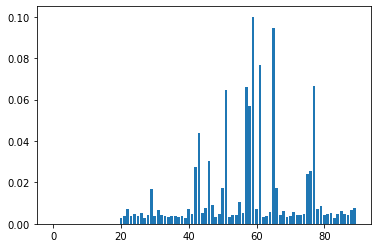

non-counted trajec: 0
elapsed time: 155 min 49 sec


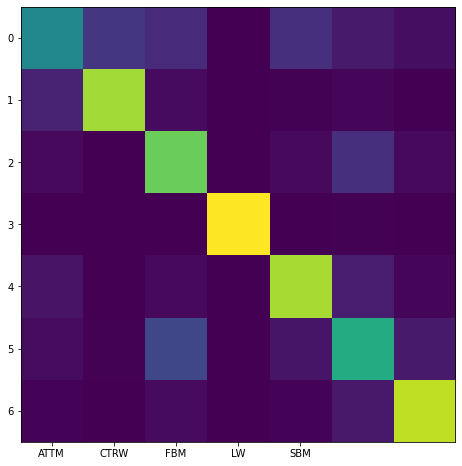

f1 micro  : 0.7766666666666666
0
0


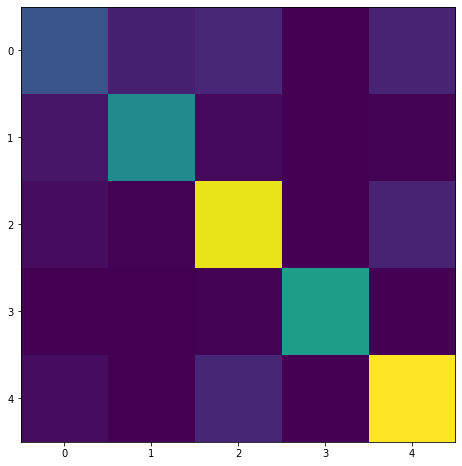

f1 micro  : 0.8292857142857143
[[ 829  285  351    0  312]
 [ 176 1538   78    0   13]
 [ 109   13 3096    6  320]
 [   0    0   15 1782    5]
 [ 112    6  349    1 3204]]


In [14]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

X = np.asarray(add_feature)
Y = np.asarray(label_set)

print(X.shape, Y.shape)
# split data into train and test sets
test_size = 0.3
# seed = 777
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed) 


model = XGBClassifier(n_estimators=100, nthread=-1, seed=888)

model.fit(X_train, y_train)
# make predictions for test data

y_pred = model.predict(X_test)
# y_pred = best_xgb.predict(X_test)


# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


print(model.feature_importances_)
# plot
plt.bar(range(len(model.feature_importances_ )), model.feature_importances_ ) 
plt.show()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

## order -> ATTM; CTRW; FBM; LW; SBM
# nsample = len(onedim_set)

        
tend = time.time()
print('non-counted trajec:', icount)
print('elapsed time: {0:.0f} min {1:.0f} sec'.format((tend-tstart)//60, (tend-tstart)%60))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
axes.imshow(confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5,6]))

axes.set_xticks(np.arange(len(model_id)))
axes.set_xticklabels(model_id)
plt.show()
print('f1 micro  :', f1_score(y_test, y_pred, average='micro') )

pickle.dump(model, open("reference_model_single_try.dat", "wb"))



convert_pred = np.zeros((len(y_pred)))
convert_true = np.zeros((len(y_test)))

icount = 0 
for i in range(len(y_pred)):
    if y_pred[i] <= 4:
        convert_pred[i] = y_pred[i]
    elif y_pred[i] == 5:
        convert_pred[i] = 2
    elif y_pred[i] == 6:
        convert_pred[i] = 4
    else:
        icount = icount + 1
print(icount)

icount = 0 
for i in range(len(y_test)):
    if y_test[i] <= 4:
        convert_true[i] = y_test[i]
    elif y_test[i] == 5:
        convert_true[i] = 2
    elif y_test[i] == 6:
        convert_true[i] = 4
    else:
        icount = icount + 1
print(icount)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
axes.imshow(confusion_matrix(convert_true, convert_pred, labels=[0,1,2,3,4]))


plt.show()
print('f1 micro  :', f1_score(convert_true, convert_pred, average='micro') )

print(confusion_matrix(convert_true, convert_pred, labels=[0,1,2,3,4]))


In [ ]:
print("Parameter optimization")
tstart = time.time()

cv_params = {
    'objective': ["reg:linear", "reg:logistic", "multi:softmax" ],
    'n_estimators': [10, 50, 100, 150],
    'max_depth': [2,4,6,8],
            }


model = XGBClassifier()
clf = GridSearchCV(model, param_grid = cv_params, iid = False, n_jobs=-1,  \
                   scoring = "f1_micro", cv = 5, verbose=1)
clf.fit(X,Y)
print(clf.best_score_)
print(clf.best_params_)

best_xgb = clf.best_estimator_
pickle.dump(best_xgb, open("reference_model.dat", "wb"))


tend = time.time()
print('elapsed time:', tend-tstart)

Parameter optimization
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.2min


In [ ]:
best_xgb = clf.best_estimator_
pickle.dump(best_xgb, open("reference_model.dat", "wb"))

